In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

In [3]:
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, to_dataframe, generate_test_dataframe, naive_propensity_estimation, masked_nb_propensity_estimation, mlp_propensity_estimation
from algo import PropensitySVD

# Visualize the effect of selection bias

In [4]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta, sample_prob=0.1)
    return P, R

beta = np.linspace(0, 2.5, 6)
results = [P_R_train(i) for i in beta]     

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kw

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_22041/2058515028.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


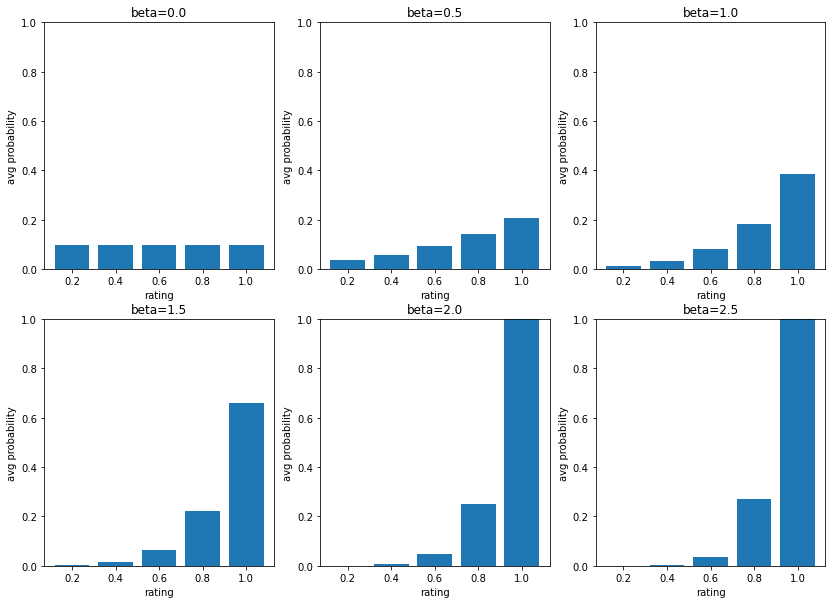

In [5]:
def average_prob(P, R):
    Ps = []
    probs = []
    for i in range(5):
        Ps.append(P.copy())
        probs.append(0)
    for i in range(5):
        Ps[i][R != (0.2 * i + 0.2)] = 0
        probs[i] = Ps[i].sum() / np.count_nonzero(Ps[i])
    return probs

fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i in range(6):
    P, R = results[i]
    probs = average_prob(P, R) 
    x_axis = ['0.2', '0.4', '0.6', '0.8', '1.0']
    axs[i // 3, i % 3].bar(x_axis, probs)
    axs[i // 3, i % 3].set(title=f'beta={beta[i]}', xlabel='rating', ylabel='avg probability', ylim=(0, 1))
fig.show()
fig.savefig('images/visualize.png', dpi=300)

# Stage 1 experiment

## ml-100k dataset


In [6]:
beta = np.linspace(0.1, 3, 10)
quantization = ['binary', 'onetothree', 'onetofive']
user_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}

algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')   

        for iteration in range(10): 
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        user_knn_result_avg[quantization[i]].append(temp_results.mean())
        user_knn_result_1q[quantization[i]].append(temp_results[2])
        user_knn_result_3q[quantization[i]].append(temp_results[7])

algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (1000, 1000), environment='ml-100k-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        item_knn_result_avg[quantization[i]].append(temp_results.mean())
        item_knn_result_1q[quantization[i]].append(temp_results[2])
        item_knn_result_3q[quantization[i]].append(temp_results[7])

algo = SVD(verbose=False)  

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (1000, 1000), environment='ml-100k-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        svd_result_avg[quantization[i]].append(temp_results.mean())
        svd_result_1q[quantization[i]].append(temp_results[2])
        svd_result_3q[quantization[i]].append(temp_results[7])

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
RMSE: 0.1576
RMSE: 0.1593
RMSE: 0.1588
RMSE: 0.1576
RMSE: 0.1580
RMSE: 0.1565
RMSE: 0.1575
RMSE: 0.1581
RMSE: 0.1598
RMSE: 0.1588
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_22041/1050720273.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


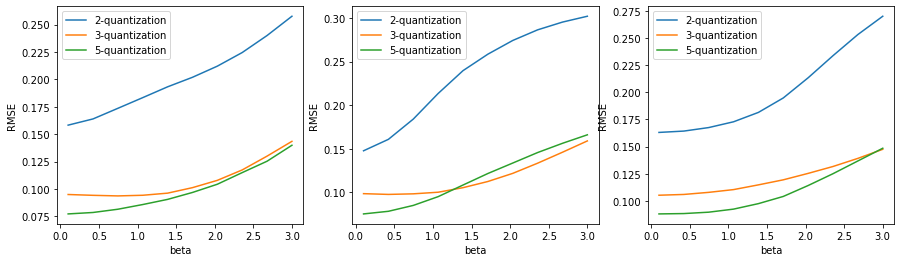

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
axs[0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
axs[0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
axs[0].set(xlabel='beta', ylabel='RMSE')
axs[0].legend(loc='upper left')

axs[1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
axs[1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
axs[1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
axs[1].set(xlabel='beta', ylabel='RMSE')
axs[1].legend(loc='upper left')

axs[2].plot(beta, svd_result_avg['binary'], label='2-quantization')
axs[2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
axs[2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
axs[2].set(xlabel='beta', ylabel='RMSE')
axs[2].legend(loc='upper left')
fig.show()
fig.savefig('images/1a.png', dpi=300)

# Synthetic dataset (`latent-static-v1`)

In [8]:
beta = np.linspace(0.1, 3, 10)
quantization = ['binary', 'onetothree', 'onetofive']
user_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}

algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
        (500, 500), environment='latent-static-v1')   

        for iteration in range(10): 
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        user_knn_result_avg[quantization[i]].append(temp_results.mean())
        user_knn_result_1q[quantization[i]].append(temp_results[2])
        user_knn_result_3q[quantization[i]].append(temp_results[7])

algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (500, 500), environment='latent-static-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        item_knn_result_avg[quantization[i]].append(temp_results.mean())
        item_knn_result_1q[quantization[i]].append(temp_results[2])
        item_knn_result_3q[quantization[i]].append(temp_results[7])

algo = SVD(verbose=False)  

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (500, 500), environment='latent-static-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        svd_result_avg[quantization[i]].append(temp_results.mean())
        svd_result_1q[quantization[i]].append(temp_results[2])
        svd_result_3q[quantization[i]].append(temp_results[7])

RMSE: 0.2266
RMSE: 0.2205
RMSE: 0.2259
RMSE: 0.2274
RMSE: 0.2212
RMSE: 0.2242
RMSE: 0.2230
RMSE: 0.2238
RMSE: 0.2254
RMSE: 0.2252
RMSE: 0.2302
RMSE: 0.2335
RMSE: 0.2296
RMSE: 0.2320
RMSE: 0.2336
RMSE: 0.2275
RMSE: 0.2341
RMSE: 0.2298
RMSE: 0.2294
RMSE: 0.2282
RMSE: 0.2497
RMSE: 0.2518
RMSE: 0.2470
RMSE: 0.2434
RMSE: 0.2512
RMSE: 0.2540
RMSE: 0.2506
RMSE: 0.2466
RMSE: 0.2492
RMSE: 0.2528
RMSE: 0.2730
RMSE: 0.2744
RMSE: 0.2690
RMSE: 0.2698
RMSE: 0.2729
RMSE: 0.2723
RMSE: 0.2653
RMSE: 0.2726
RMSE: 0.2778
RMSE: 0.2751
RMSE: 0.2856
RMSE: 0.2782
RMSE: 0.2792
RMSE: 0.2797
RMSE: 0.2819
RMSE: 0.2811
RMSE: 0.2875
RMSE: 0.2770
RMSE: 0.2805
RMSE: 0.2823
RMSE: 0.3042
RMSE: 0.3020
RMSE: 0.3003
RMSE: 0.3015
RMSE: 0.3108
RMSE: 0.3061
RMSE: 0.3011
RMSE: 0.3008
RMSE: 0.3048
RMSE: 0.3030
RMSE: 0.3279
RMSE: 0.3269
RMSE: 0.3195
RMSE: 0.3294
RMSE: 0.3285
RMSE: 0.3253
RMSE: 0.3260
RMSE: 0.3321
RMSE: 0.3298
RMSE: 0.3293
RMSE: 0.3277
RMSE: 0.3279
RMSE: 0.3255
RMSE: 0.3344
RMSE: 0.3290
RMSE: 0.3342
RMSE: 0.3255

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_22041/3075710574.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


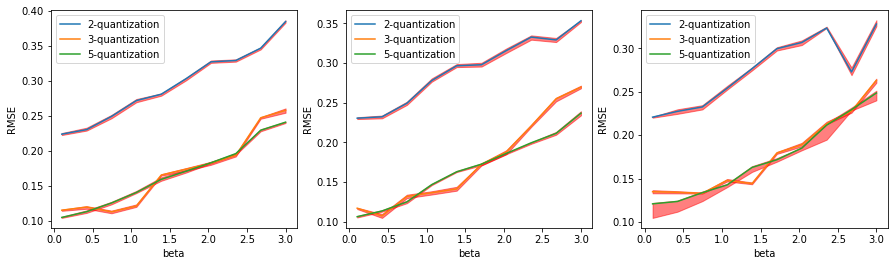

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
axs[0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
axs[0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
axs[0].fill_between(beta, user_knn_result_1q['binary'],
                    user_knn_result_3q['binary'], color='red', alpha=0.5)
axs[0].fill_between(beta, user_knn_result_1q['onetothree'],
                    user_knn_result_3q['onetothree'], color='red', alpha=0.5)
axs[0].fill_between(beta, user_knn_result_1q['onetofive'],
                    user_knn_result_3q['onetofive'], color='red', alpha=0.5)
axs[0].set(xlabel='beta', ylabel='RMSE')
axs[0].legend(loc='upper left')

axs[1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
axs[1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
axs[1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
axs[1].fill_between(beta, item_knn_result_1q['binary'],
                    item_knn_result_3q['binary'], color='red', alpha=0.5)
axs[1].fill_between(beta, item_knn_result_1q['onetothree'],
                    item_knn_result_3q['onetothree'], color='red', alpha=0.5)
axs[1].fill_between(beta, item_knn_result_1q['onetofive'],
                    item_knn_result_3q['onetofive'], color='red', alpha=0.5)
axs[1].set(xlabel='beta', ylabel='RMSE')
axs[1].legend(loc='upper left')

axs[2].plot(beta, svd_result_avg['binary'], label='2-quantization')
axs[2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
axs[2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
axs[2].fill_between(beta, svd_result_1q['binary'],
                    svd_result_3q['binary'], color='red', alpha=0.5)
axs[2].fill_between(beta, svd_result_1q['onetothree'],
                    svd_result_3q['onetothree'], color='red', alpha=0.5)
axs[2].fill_between(beta, user_knn_result_1q['onetofive'],
                   svd_result_3q['onetofive'], color='red', alpha=0.5)
axs[2].set(xlabel='beta', ylabel='RMSE')
axs[2].legend(loc='upper left')
fig.show()
fig.savefig('images/1b.png', dpi=300)


# Stage 2 experiment

## ml-100k dataset

In [10]:
beta = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8])
p = [0] * 10
results_better = [0] * 10
results = [0] * 10

for it in range(1):
    truth = generate_ground_truth_matrix((1000, 1000), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=3)
    train_df = to_dataframe(ratings)    
    for i in range(10):
        p[i] = masked_nb_propensity_estimation(truth, ratings, P.shape, beta=beta[i])
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(
        train_df[['userID', 'itemID', 'rating']], reader)
    trainset = data.build_full_trainset()
    test_df = generate_test_dataframe(R_no_noise)
    testset = Dataset.load_from_df(
        test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
    for i in range(10):
        algo_better = PropensitySVD(p[i], n_epochs=20)
        algo = SVD(n_epochs=20)
        algo_better.fit(trainset)
        algo.fit(trainset)
        results_better[i] += accuracy.rmse(algo_better.test(testset))
        results[i] += accuracy.rmse(algo.test(testset))
results_better = np.array(results_better) / 10
results = np.array(results) / 10

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
RMSE: 0.1112
RMSE: 0.1491
RMSE: 0.1109
RMSE: 0.1491
RMSE: 0.1113
RMSE: 0.1487
RMSE: 0.1108
RMSE: 0.1488
RMSE: 0.1114
RMSE: 0.1485
RMSE: 0.1111
RMSE: 0.1497
RMSE: 0.1115
RMSE: 0.1491
RMSE: 0.1114
RMSE: 0.1497
RMSE: 0.1112
RMSE: 0.1495
RMSE: 0.1114
RMSE: 0.1494


## Synthetic dataset

In [11]:
beta = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8])
p = [0] * 10
results_better_synthetic = [0] * 10
results_synthetic = [0] * 10

for it in range(1):
    truth = generate_ground_truth_matrix((500, 500), environment='latent-static-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=3)
    train_df = to_dataframe(ratings)    
    for i in range(10):
        p[i] = masked_nb_propensity_estimation(truth, ratings, P.shape, beta[i])
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(
        train_df[['userID', 'itemID', 'rating']], reader)
    trainset = data.build_full_trainset()
    test_df = generate_test_dataframe(R_no_noise)
    testset = Dataset.load_from_df(
        test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
    for i in range(10):
        algo_better = PropensitySVD(p[i], n_epochs=20)
        algo = SVD(n_epochs=20)
        algo_better.fit(trainset)
        algo.fit(trainset)
        results_better_synthetic[i] += accuracy.rmse(algo_better.test(testset))
        results_synthetic[i] += accuracy.rmse(algo.test(testset))
results_better_synthetic = np.array(results_better) / 1   
results_synthetic = np.array(results) / 1


/Users/fengyuli/Desktop/Sarah's Group/repo/data_utils.py:313: RuntimeWarning: divide by zero encountered in true_divide
  result = np.divide(numerator, denominator)


RMSE: 0.2161
RMSE: 0.2428
RMSE: 0.2183
RMSE: 0.2444
RMSE: 0.2161
RMSE: 0.2430
RMSE: 0.2182
RMSE: 0.2459
RMSE: 0.2180
RMSE: 0.2429
RMSE: 0.2174
RMSE: 0.2428
RMSE: 0.2182
RMSE: 0.2442
RMSE: 0.2184
RMSE: 0.2409
RMSE: 0.2201
RMSE: 0.2438
RMSE: 0.2180
RMSE: 0.2437


/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_22041/3740760302.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


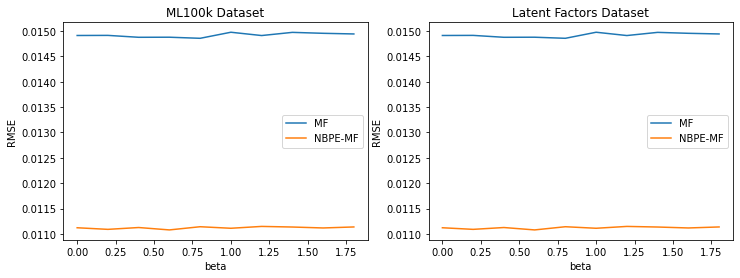

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(beta, results, label='MF')
axs[0].plot(beta, results_better, label='NBPE-MF')
axs[0].legend()
axs[0].set(xlabel='beta', ylabel='RMSE', title='ML100k Dataset')
axs[1].plot(beta, results_synthetic, label='MF')
axs[1].plot(beta, results_better_synthetic, label='NBPE-MF')
axs[1].legend()
axs[1].set(xlabel='beta', ylabel='RMSE', title='Latent Factors Dataset')
fig.show()
fig.savefig('images/2.png', dpi=300)